# **Redes Neurais e Aprendizado Profundo**

## GAN (Generative Adversarial Network)

The purpose of this notebook is to provide an introduction to the concept and operation of Generative Adversarial Networks (GANs).

In this particular example, we train a GAN to generate data points that follow a quadratic function.

The GAN consists of two essential components:

- Generator: This model's primary role is to take latent vectors as input and generate synthetic samples in such a way that they closely resemble real data points. The generator aims to deceive the discriminator by creating fake examples that are difficult to distinguish from real ones.

- Discriminator: This component is responsible for categorizing samples as either real or fake. Its objective is to accurately differentiate between real and generated data points.

The interaction between the generator and discriminator can be viewed as a minimax game. The generator tries to fool the discriminator by producing synthetic samples that are indistinguishable from real ones, while the discriminator seeks to maintain its ability to correctly classify all samples.

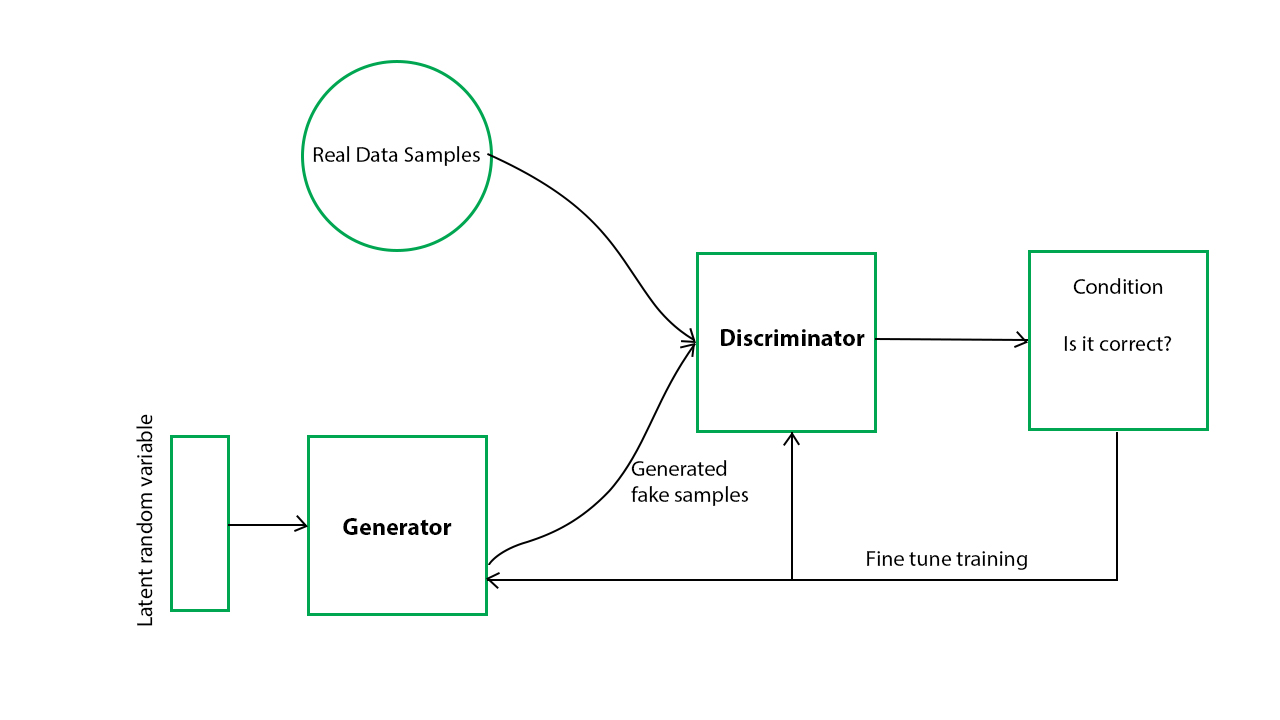

In [397]:
# Importation

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy.random import rand
import random

# Seting seed
torch.manual_seed(42)
random.seed(42)


## Quadratic function

Generate n samples of quadratic coordinates (x, y), y = x²

In [398]:
def quadratic_function(n):
    # n is the number os samples
    # generate n numbers from -0.5 to 0.5
    x = rand(n) - 0.5

    # transforming the numpy array to tensor and changing the dtype to float32
    x = torch.tensor(x).to(dtype=torch.float32)
    x = x.view(-1, 1)

    # quadratic
    y = x**2

    # concatenate x and y
    return torch.cat((x,y), 1)

In [399]:
test = quadratic_function(8)
print(test)
print(test.shape)

tensor([[-0.4973,  0.2473],
        [-0.3967,  0.1573],
        [-0.3033,  0.0920],
        [-0.0390,  0.0015],
        [ 0.1991,  0.0396],
        [ 0.1611,  0.0260],
        [-0.2439,  0.0595],
        [ 0.4462,  0.1991]])
torch.Size([8, 2])


In [400]:
test.shape

torch.Size([8, 2])

## GAN model

### Generator Model


In [401]:
latent_size = 5

In [402]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 15),
            nn.ReLU(),
            nn.Linear(15, 2)
        )

        # initializing the weights
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
    def forward(self, z):
        return self.model(z)

In [403]:
generator = Generator()

### Discriminator Model

In [404]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.LeakyReLU(0.01),
            nn.Linear(25, 15),
            nn.LeakyReLU(0.01),
            nn.Linear(15, 10),
            nn.LeakyReLU(0.01),
            nn.Linear(10, 5),
            nn.LeakyReLU(0.01),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

        # initializing the weights
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x)

In [405]:
discriminator = Discriminator()

## Hyperparameters

In [406]:
lr = 0.001
epochs = 5000
n = 128

## Optimizer and Loss

In [407]:
# generator optimizer
optimizer_g = torch.optim.Adam(generator.parameters(), lr = lr)
# discriminator optimizer
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = lr)
# loss
criterion = nn.BCELoss()

## Training

In [408]:
g_losses = []
d_losses = []

for epoch in range(epochs):

    # Discriminator training for real examples

    # generating real samples
    real = quadratic_function(n)
    # label for real data is 1
    label = torch.ones(n, 1)
    # resetting the gradients
    discriminator.zero_grad()
    # passing the real samples through the discriminator
    output = discriminator(real)
    # calculating the Loss
    loss_d_real = criterion(output, label)
    loss_d_real.backward()

    
    # Discriminator training for fake examples

    # generating the latent vectors
    z = torch.randn(n, latent_size)
    # generating the fake samples
    fake = generator(z)
    # label for fake data is 0
    label.fill_(0)
    # passing the fake samples through the discriminator
    output = discriminator(fake.detach())
    # calculating the loss
    loss_d_fake = criterion(output, label)  
    loss_d_fake.backward() 

    # backpropagation
    loss_d = loss_d_real + loss_d_fake
    optimizer_d.step()


    # Generator training

    # resetting the gradients
    generator.zero_grad()
    # creating inverted labels for fake data
    # since the generator wants to fool the discriminator
    label.fill_(1)
    # passing the fake samples through the discriminator
    output = discriminator(fake)
    # calculating the loss
    loss_g = criterion(output, label)
    loss_g.backward()
    
    # backpropagation
    optimizer_g.step()

    g_losses.append(loss_g.item())
    d_losses.append(loss_d.item())

    if (epoch+1)%1000 == 0:
        print('\nEpoch:', epoch+1, '\nDiscriminator Loss:', loss_d.item(), '\nGenerator Loss:', loss_g.item())



Epoch: 1000 
Discriminator Loss: 1.061952829360962 
Generator Loss: 1.1046181917190552

Epoch: 2000 
Discriminator Loss: 1.218841791152954 
Generator Loss: 1.1018794775009155

Epoch: 3000 
Discriminator Loss: 1.1556451320648193 
Generator Loss: 1.3406094312667847

Epoch: 4000 
Discriminator Loss: 1.0800656080245972 
Generator Loss: 1.0153207778930664

Epoch: 5000 
Discriminator Loss: 1.065830945968628 
Generator Loss: 1.3291269540786743


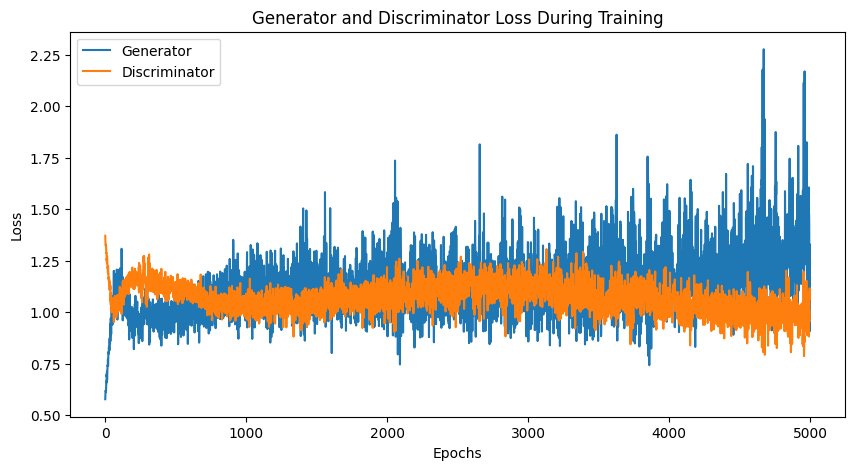

In [411]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Testing the Generator and visualizing the results

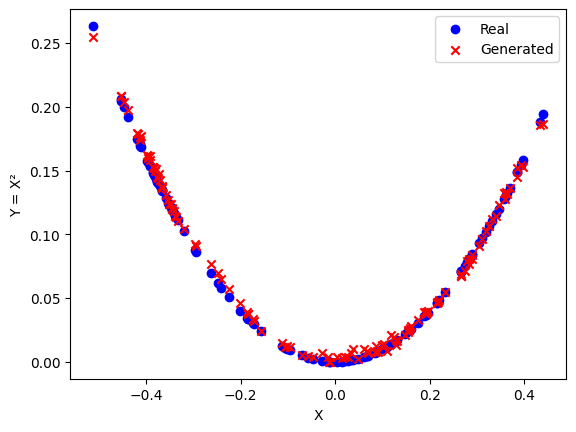

In [410]:
# mode eval of the generator
generator.eval()

# fake data
out = generator(torch.randn(n, latent_size))
x2, y2 = zip(*out.detach().numpy())
 
# real data
x1, y1 = [], []
for i in out.detach().numpy():
    x, y = i
    x1.append(x)
    y1.append(x**2)


plt.scatter(x1, y1, label='Real', marker='o', color='blue')
plt.scatter(x2, y2, label='Generated', marker='x', color='red')

plt.xlabel('X')
plt.ylabel('Y = X²')
plt.legend()
plt.show()
